#### Analyzing the Air Pollution Spike Caused by the fires

Last December 2017, we were analyzing __[*Thomas fire air pollution spike*](hhttps://medium.com/planet-os/analyzing-the-air-pollution-spike-caused-by-the-thomas-fire-3830a1aa60df)__, which was one of the largest wildfires in the California's history. 

Now, half a year later, California and also other states are suffering in large wild fires again. The scope of California's fires is unprecedented and firefighters battle 17 fires, one of which is even larger than Thomas fire and it is considered as a largest wildfire in California's history. 

The ongoing __[*Mendocino Complex Fire*](https://eu.usatoday.com/story/news/2018/08/08/california-fires-mendocino-complex-fire/943899002/)__ in North California has already burned across 344,890 acres (13 Aug). In the same time __[*Carr Fire*](https://en.wikipedia.org/wiki/Carr_Fire)__ has burned already 206,816 acres (13. Aug) in Shasta and Trinity Counties and Ferguson Fire has burned 96,457 acres (13 Aug). As well as several fires in the southern part of California. All these fires are  causing hazardous air pollution in the regions. In addition to California, Oregon, Washington and Idaho suffer in wild fires as well. In light of that, we would like to introduce a __[high-quality global air pollution dataset](http://data.planetos.com/datasets/cams_nrt_forecasts_global)__ we have in the Planet OS Datahub that provides a 5-day air quality forecast.

The Copernicus Atmosphere Monitoring Service uses a comprehensive global monitoring and forecasting system that estimates the state of the atmosphere on a daily basis, combining information from models and observations, to provide a daily 5-day global surface forecast. 

The __[Planet OS Datahub](http://data.planetos.com)__ provides 28 different variables from the CAMS Air Quality Forecast dataset. I’ve used PM2.5 in the analysis as these particles, often described as the fine particles, are up to 30 times smaller than the width of a human hair. These tiny particles are small enough to be breathed deep into the lungs, making them very dangerous to people’s health.

As we would like to have data about the Continental United States we will download data by using Package API. Then we will create a widget where you can choose timestamp by using a slider. After that, we will also save the same data as a GIF to make sharing the results with friends and colleagues more fun. And finally, we make a plot from the California's most populated cities air quality - San Fransisco and Los Angeles.


In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import dh_py_access.lib.datahub as datahub
import xarray as xr
import matplotlib.pyplot as plt
import ipywidgets as widgets
from mpl_toolkits.basemap import Basemap
import dh_py_access.package_api as package_api
import matplotlib.colors as colors
import warnings
import shutil
import imageio
import os
warnings.filterwarnings("ignore")

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [2]:
server = 'api.planetos.com'
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'

At first, we need to define the dataset name and a variable we want to use.

In [3]:
dh = datahub.datahub(server,version,API_key)
dataset = 'cams_nrt_forecasts_global'
variable_name1 = 'pm2p5'

Then we define spatial range. We decided to analyze US, where unfortunately catastrofic wildfires are taking place at the moment and influeces air quality. 

In [4]:
area_name = 'USA'

latitude_north = 49.138; longitude_west = -128.780
latitude_south = 24.414; longitude_east = -57.763

### Download the data with package API

1. Create package objects
2. Send commands for the package creation
3. Download the package files

In [5]:
package_cams = package_api.package_api(dh,dataset,variable_name1,longitude_west,longitude_east,latitude_south,latitude_north,area_name=area_name)

In [6]:
package_cams.make_package()

{'packageSubmitted': True, 'packageStatus': {'message': 'success'}, 'packageResult': {'success': True}}
Package exists


In [7]:
package_cams.download_package()

### Work with the downloaded files

We start with opening the files with xarray and adding PM2.5 as micrograms per cubic meter as well to make the values easier to understand and compare. After that, we will create a map plot with a time slider, then make a GIF using the images, and finally, we will look into a specific location.

In [8]:
dd1 = xr.open_dataset(package_cams.local_file_name)
dd1['longitude'] = ((dd1.longitude+180) % 360) - 180
dd1['pm2p5_micro'] = dd1.pm2p5 * 1000000000.
dd1.pm2p5_micro.data[dd1.pm2p5_micro.data < 0] = np.nan

Here we are making a Basemap of the US that we will use for showing the data.

In [9]:
m = Basemap(projection='merc', lat_0 = 55, lon_0 = -4,
         resolution = 'i', area_thresh = 0.05,
         llcrnrlon=longitude_west, llcrnrlat=latitude_south,
         urcrnrlon=longitude_east, urcrnrlat=latitude_north)
lons,lats = np.meshgrid(dd1.longitude.data,dd1.latitude.data)
lonmap,latmap = m(lons,lats)

Now it is time to plot all the data. A great way to do it is to make an interactive widget, where you can choose time stamp by using a slider. 

As the minimum and maximum values are very different, we are using logarithmic colorbar to visualize it better.

On the map we can see that the very high PM2.5 values are in different states. Maximums are most of the time near 1000 µg/m3, which is way larger than the norm (25 µg/m3). By using the slider we can see the air quality forecast, which shows how the pollution is expected to expand. 

We are also adding a red dot to the map to mark the area, where the PM2.5 is the highest. Seems like it is moving a lot and many wild fires are influencing it. We can also see that most of the Continental US is having PM2.5 values below the standard, which is 25 µg/m3, but in the places where wild fires taking place, values tend to be at least over 100 µg/m3.

In [10]:
vmax = np.nanmax(dd1.pm2p5_micro.data)
vmin = 2

In [11]:
def loadimg(k):
    fig=plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    pcm = m.pcolormesh(lonmap,latmap,dd1.pm2p5_micro.data[k],
                norm = colors.LogNorm(vmin=vmin, vmax=vmax),cmap = 'rainbow')
    ilat,ilon = np.unravel_index(np.nanargmax(dd1.pm2p5_micro.data[k]),dd1.pm2p5_micro.data[k].shape)
    #m.plot(lonmap[ilat,ilon],latmap[ilat,ilon],'r')
    m.scatter(lonmap[ilat,ilon],latmap[ilat,ilon],s=58,facecolors='none',edgecolors='r')

    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    cbar = plt.colorbar(pcm,fraction=0.02, pad=0.040,ticks=[10**0, 10**1, 10**2,10**3])
    cbar.ax.set_yticklabels([0,10,100,1000]) 
    plt.title(str(dd1.pm2p5_micro.time[k].data)[:-10])
    cbar.set_label('micrograms m^3')
    print("Maximum: ","%.2f" % np.nanmax(dd1.pm2p5_micro.data[k]))

    plt.show()
widgets.interact(loadimg, k=widgets.IntSlider(min=0,max=(len(dd1.pm2p5_micro.data)-1),step=1,value=0, layout=widgets.Layout(width='100%')))

<function __main__.loadimg>

Let's include an image from the last time-step as well, because GitHub Preview doesn't show the time slider images. 

Maximum:  1124.65


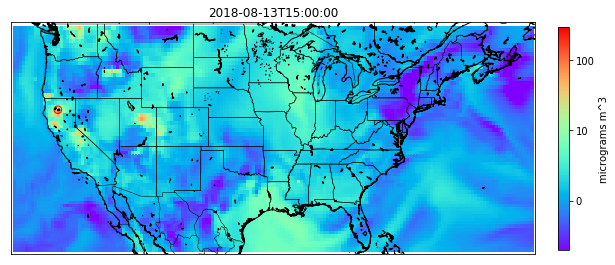

In [12]:
loadimg(3)

With the function below we will save images you saw above to the local filesystem as a GIF, so it is easily shareable with others. 

In [13]:
def make_ani():
    folder = './anim/'
    for k in range(len(dd1.pm2p5_micro)):
        filename = folder + 'ani_' + str(k).rjust(3,'0') + '.png'
        if not os.path.exists(filename):
            fig=plt.figure(figsize=(10,7))
            ax = fig.add_subplot(111)
            pcm = m.pcolormesh(lonmap,latmap,dd1.pm2p5_micro.data[k],
                        norm = colors.LogNorm(vmin=vmin, vmax=vmax),cmap = 'rainbow')
            m.drawcoastlines()
            m.drawcountries()
            m.drawstates()
            cbar = plt.colorbar(pcm,fraction=0.02, pad=0.040,ticks=[10**0, 10**1, 10**2,10**3])
            cbar.ax.set_yticklabels([0,10,100,1000]) 
            plt.title(str(dd1.pm2p5_micro.time[k].data)[:-10])
            ax.set_xlim()
            cbar.set_label('micrograms m^3')
            if not os.path.exists(folder):
                os.mkdir(folder)
            plt.savefig(filename,bbox_inches = 'tight')
            plt.close()

    files = sorted(os.listdir(folder))
    images = []
    for file in files:
        if not file.startswith('.'):
            filename = folder + file
            images.append(imageio.imread(filename))
    kargs = { 'duration': 0.1,'quantizer':2,'fps':5.0}
    imageio.mimsave('cams_pm2p5.gif', images, **kargs)
    print ('GIF is saved as cams_pm2p5.gif under current working directory')
    shutil.rmtree(folder)
make_ani()

GIF is saved as cams_pm2p5.gif under current working directory


To see data more specifically we need to choose the location. This time we decided to look into Los Angeles and San Fransisco, as the most populated cities in California.

In [14]:
lon = -118; lat = 34
data_in_spec_loc = dd1.sel(longitude = lon,latitude=lat,method='nearest')
print ('Latitude ' + str(lat) + ' ; Longitude ' + str(lon))

Latitude 34 ; Longitude -118


In the plot below we can see the PM2.5 forecast on the surface layer. Note that the time zone on the graph is UTC while the time zone in San Fransisco and Los Angeles is UTC-08:00. The air pollution from the wildfire has exceeded a record  100 µg/m3, while the hourly norm is 25 µg/m3. We can also see some peaks every day around 12 pm UTC (4 am PST) and the lowest values are around 12 am UTC (4 pm PST). 

Daily pm 2.5 values are mostly in the norm, while the values will continue to be high during the night. This daily pattern where the air quality is the worst at night is caused by the __[*temperature inversion*](http://en.ilmatieteenlaitos.fi/temperature-inversions)__. As the land is not heated by the sun during the night, and the winds tend to be weaker as well, the pollution gets trapped near the ground. Pollution also tends to be higher in the winter time when the days are shorter. Thankfully day time values are much smaller.

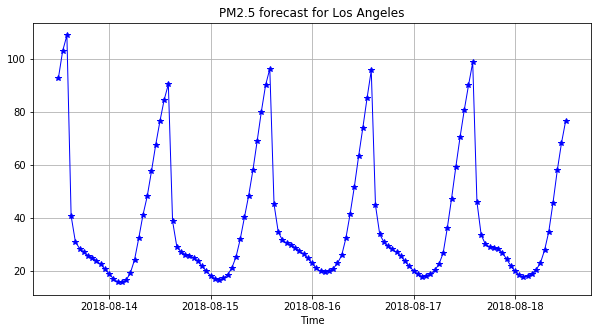

In [15]:
fig = plt.figure(figsize=(10,5))
plt.plot(data_in_spec_loc.time,data_in_spec_loc.pm2p5_micro, '*-',linewidth = 1,c='blue',label = dataset) 
plt.xlabel('Time')
plt.title('PM2.5 forecast for Los Angeles')
plt.grid()

In [16]:
lon = -122.4; lat = 37.7
data_in_spec_loc = dd1.sel(longitude = lon,latitude=lat,method='nearest')
print ('Latitude ' + str(lat) + ' ; Longitude ' + str(lon))

Latitude 37.7 ; Longitude -122.4


Thankfully, San Fransisco air quality is in the norm even in the night time. However, we have to be careful as it could easily change with the wind direction as the fires are pretty close to the city. We can also see that in the end of the forecast values are rising quite rapidly. 

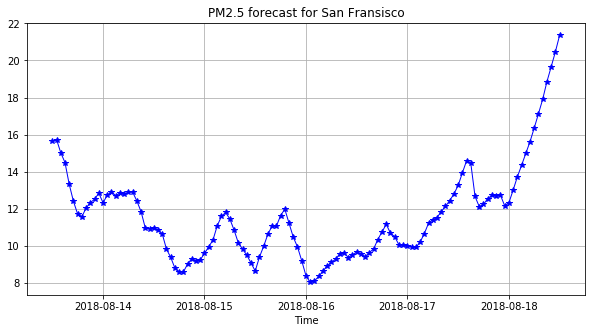

In [17]:
fig = plt.figure(figsize=(10,5))
plt.plot(data_in_spec_loc.time,data_in_spec_loc.pm2p5_micro, '*-',linewidth = 1,c='blue',label = dataset) 
plt.xlabel('Time')
plt.title('PM2.5 forecast for San Fransisco')
plt.grid()

Finally, we will remove the package we downloaded. 

In [18]:
os.remove(package_cams.local_file_name)

This analysis is made on August 14, 2018. 